<a href="https://colab.research.google.com/github/SeifxMahmoud/Flood-Detection/blob/main/FloodDetection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Setting Env

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.image as tfi
import random
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io

# Data Preperation

In [ ]:
images_dir = '/content/drive/MyDrive/satalite data/data/images'
labels_dir= '/content/drive/MyDrive/satalite data/data/labels'

In [ ]:
def load_data(images,labels, img_size= (128,128)):
  image_filenames= sorted(os.listdir(images_dir))
  label_filenames= sorted(os.listdir(labels_dir))

  images= np.array([io.imread(os.path.join(images_dir, img)) for img in image_filenames])
  labels= np.array([io.imread(os.path.join(labels_dir, label)) for label in label_filenames])
  images= tf.cast(images, tf.float32)
  labels= tf.cast(labels, tf.float32)
  images= images / 255.0
  labels= labels / 255.0

  return images, labels

In [ ]:
images, labels = load_data(images_dir, labels_dir)

In [ ]:
print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)
print("Images Data Type:", images.dtype)
print("Labels Data Type:", labels.dtype)
print("Sample Image Data:", images[0]) # dispaly the first image and label
print("Sample Label Data:", labels[0])

Images Shape: (306, 128, 128, 12)
Labels Shape: (456, 128, 128)
Images Data Type: <dtype: 'float32'>
Labels Data Type: <dtype: 'float32'>
Sample Image Data: tf.Tensor(
[[[0.5137255  0.1882353  0.28627452 ... 1.2392157  0.3137255  0.        ]
  [0.5568628  0.16078432 0.2901961  ... 1.2392157  0.3137255  0.        ]
  [0.5568628  0.19607843 0.34509805 ... 1.2431372  0.11764706 0.        ]
  ...
  [1.082353   0.91764706 1.7686274  ... 1.0039216  0.03921569 0.        ]
  [1.082353   0.94509804 1.8784313  ... 0.98039216 0.03921569 0.        ]
  [1.054902   0.9019608  1.6313726  ... 0.96862745 0.03921569 0.        ]]

 [[0.6784314  0.4509804  0.9529412  ... 1.254902   0.3137255  0.        ]
  [0.6        0.4117647  0.8392157  ... 1.2588235  0.3137255  0.        ]
  [0.6        0.45490196 0.84313726 ... 1.2666667  0.03921569 0.        ]
  ...
  [1.3019608  1.2039216  1.9764706  ... 0.96862745 0.03921569 0.        ]
  [1.3019608  1.0627451  1.972549   ... 0.9490196  0.03921569 0.        ]
  [1

In [ ]:
# since there's a mismatch between images and labels.
# Storing correct label format in an array.

def filter_labels(labels_dir, img_size= (128,128)):
  label_filenames= os.listdir(labels_dir)
  valid_labels= [label for label in label_filenames if '_' not in label]
  image_filenames= os.listdir(images_dir)
  valid_images= [img for img in image_filenames if os.path.splitext(img)[0] in [os.path.splitext(label)[0] for label in valid_labels]]
  images = np.array([io.imread(os.path.join(images_dir, img)) for img in valid_images])
  labels = np.array([io.imread(os.path.join(labels_dir, label)) for label in valid_labels])
  return images, labels, valid_labels, valid_images
images, labels, valid_images, valid_labels = filter_labels(images_dir, labels_dir)
print("Filtered Images Shape:", images.shape)
print("Filtered Labels Shape:", labels.shape)
print("Valid Labels:", valid_labels)
print("Valid Images:", valid_images)


Filtered Images Shape: (306, 128, 128, 12)
Filtered Labels Shape: (306, 128, 128, 12)
Valid Labels: ['0.tif', '1.tif', '3.tif', '8.tif', '5.tif', '7.tif', '9.tif', '6.tif', '4.tif', '10.tif', '16.tif', '12.tif', '14.tif', '13.tif', '11.tif', '15.tif', '17.tif', '23.tif', '18.tif', '22.tif', '19.tif', '20.tif', '21.tif', '24.tif', '25.tif', '27.tif', '26.tif', '29.tif', '28.tif', '33.tif', '30.tif', '35.tif', '36.tif', '31.tif', '34.tif', '32.tif', '37.tif', '40.tif', '38.tif', '42.tif', '39.tif', '41.tif', '43.tif', '48.tif', '44.tif', '46.tif', '49.tif', '47.tif', '45.tif', '50.tif', '51.tif', '55.tif', '54.tif', '52.tif', '56.tif', '53.tif', '60.tif', '62.tif', '63.tif', '61.tif', '58.tif', '57.tif', '59.tif', '64.tif', '71.tif', '67.tif', '66.tif', '70.tif', '65.tif', '69.tif', '68.tif', '76.tif', '72.tif', '77.tif', '73.tif', '75.tif', '74.tif', '80.tif', '81.tif', '78.tif', '84.tif', '79.tif', '82.tif', '83.tif', '91.tif', '87.tif', '86.tif', '90.tif', '85.tif', '89.tif', '88.tif'

# Data Visualization and Augmentation

In [ ]:
def denoise_image(image):
  denoised_image= cv2.GaussianBlur(image, (5,5), 0)
  denoised_image= cv2.medianBlur(denoised_image, 5)
  denoised_image= cv2.bilateralFilter(denoised_image, 9, 75, 75)
  return denoised_image

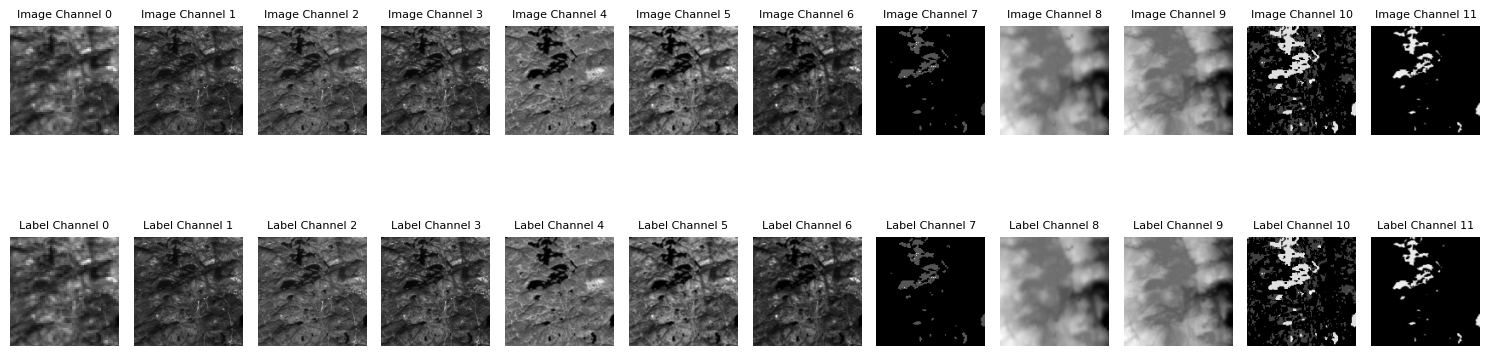

In [ ]:
import matplotlib.pyplot as plt

def visualize_all_channels(image, label, index=0):
    num_channels = image.shape[-1]
    fig, axs = plt.subplots(2, num_channels, figsize=(15, 5))

    for i in range(num_channels):
        img = image[index, :, :, i]
        lbl = label[index, :, :, i]

        # Image
        axs[0, i].imshow(img, cmap='gray')
        axs[0, i].set_title(f'Image Channel {i}', fontsize=8)
        axs[0, i].axis('off')

        # Label
        axs[1, i].imshow(lbl, cmap='gray')
        axs[1, i].set_title(f'Label Channel {i}', fontsize=8)
        axs[1, i].axis('off')

    # Adjust layout to avoid overlapping
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.tight_layout()
    plt.show()

visualize_all_channels(images, labels, index=0)


In [ ]:
from sklearn.model_selection import train_test_split

def augment_image_and_label(images, labels):
    # Horizontal flip
    if np.random.random() > 0.5:
        images = np.fliplr(images)
        labels = np.fliplr(labels)

    # Vertical flip
    if np.random.random() > 0.5:
        images = np.flipud(images)
        labels = np.flipud(labels)

    # Rotation (randomly select 90, 180, 270 degrees)
    angle = np.random.choice([0, 90, 180, 270])
    if angle > 0:
        images = np.rot90(images, k=angle // 90)
        labels = np.rot90(labels, k=angle // 90)

    # Random Zoom
    zoom_factor = np.random.uniform(0.8, 1.2)
    h, w = images.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    images = tf.images.resize(images, (new_h, new_w))
    labels = tf.images.resize(labels, (new_h, new_w))

    # Center crop or pad to original size
    if zoom_factor > 1.0:
        images = tf.images.central_crop(images, central_fraction=0.8)
        labels = tf.images.central_crop(labels, central_fraction=0.8)
    else:
        images = tf.images.resize_with_crop_or_pad(images, h, w)
        labels = tf.images.resize_with_crop_or_pad(labels, h, w)

    return images, labels


In [ ]:
def augment_batch(images, labels):
    augmented_images, augmented_labels = [], []
    for img, label in zip(images, labels):
        aug_img, aug_lab = augment_image_and_label(img, label)
        augmented_images.append(aug_img)
        augmented_labels.append(aug_lab)

    return np.array(augmented_images), np.array(augmented_labels)

# U-Net Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model
def UNET(input_shape= (128,128,12), dropout_rate= 0.2):
  inputs= keras.Input(input_shape)

  #encoder

  c1= Conv2D(64,(3,3), activation='relu', padding='same')(inputs)
  c1= Conv2D(64, (3,3), activation='relu', padding='same')(c1)
  c1= Dropout(dropout_rate)(c1)
  p1= MaxPooling2D((2,2))(c1)

  c2= Conv2D(128,(3,3), activation='relu', padding='same')(p1)
  c2= Conv2D(128, (3,3), activation='relu', padding='same')(c2)
  c2= Dropout(dropout_rate)(c2)
  p2= MaxPooling2D((2,2))(c2)

  #bottleneck

  c3= Conv2D(256,(3,3), activation='relu', padding='same')(p2)
  c3= Conv2D(256, (3,3), activation='relu', padding='same')(c3)
  c3= Dropout(dropout_rate)(c3)

  #decoder

  u4= UpSampling2D((2,2))(c3)
  u4= concatenate([u4, c2])
  c4= Conv2D(128,(3,3), activation='relu', padding='same')(u4)
  c4= Conv2D(128, (3,3), activation='relu', padding='same')(c4)
  c4= Dropout(dropout_rate)(c4)

  u5= UpSampling2D((2,2))(c4)
  u5= concatenate([u5, c1])
  c5= Conv2D(64,(3,3), activation='relu', padding='same')(u5)
  c5= Conv2D(64, (3,3), activation='relu', padding='same')(c5)
  c5= Dropout(dropout_rate)(c5)

  outputs= Conv2D(1, (1,1), activation='sigmoid')(c5)

  model= Model(inputs= inputs, outputs= outputs)
  return model

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32
)